### Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import stat
import scipy.stats as st
import seaborn as sns
import itertools
from statsmodels.stats.multitest import multipletests

In [2]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [3]:
from fitter import Fitter
import statsmodels.api as sm 

In [4]:
from sklearn.preprocessing import PowerTransformer

In [5]:
from scipy import optimize

### Importación de datos

In [6]:
df = pd.read_csv('forestfires.csv')

In [7]:
dic = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7, 'aug':8, 'sep':9,'oct':10,'nov':11,'dec':12}
dic2 = {'mon':1,'tue':2,'wed':3,'thu':4,'fri':5,'sat':6,'sun':7}
df['month'] = df['month'].apply(lambda x: dic[x])
df['day'] = df['day'].apply(lambda x: dic2[x])

In [8]:
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,8,7,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,8,7,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,8,7,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,8,6,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [9]:
## Transformaciones de los datos
df['newarea'] = df['area'].apply(lambda x: np.log(x+1))
df['lnISI'] = df['ISI'].apply(lambda x: np.log(x+1))
df['transf'] = 7*df['X'] - df['Y']

In [10]:
variables = ['ISI','DC','DMC','newarea']

### Pruebas de Kruskal-Wallis  y de Levene

De acuerdo con el trabajo de Flores, Miranda y Villasis títulado El protocolo de investigación VI: cómo elegir la prueba
estadística adecuada, para el caso de comparar más de 3 grupos de variables cuantitativas sin distribución normal la prueba recomendada es la prueba de Kruskal- Wallis en el caso de muestras independientes.  

El test H de Kruskal-WALLIS dice en la hipótesis nula que la media de la población de todos los grupos es igual, es una versión no paramétrica del test ANOVA y funciona para dos o más muestras independientes que pueden tener diferentes tamaños y permite determinar si dos o más muestras pertenecen a la misma distribución.  

Una de las condiciones es la homoestadicidad de los datos para lo cuál se tiene que comprobar que los datos presentan la misma varianza, para ello existen dos pruebas, la primera es la prueba de Bartlett que se utiliza para datos que se pueden modelar con una distribución normal y la prueba de Levene para la cuál no es necesario que se cumpla esta condición.
  
Uno de los inconveniente de la prueba de Kruskal-Wallis está en el caso de que el p-value sea muy pequeño y se descarte la hipotesis nula no se especifica en que grupos la hipotesis nula falla por lo que se requiere de otras pruebas estadisticas como las pruebas de correción de Bonferroni o de Holm.

##  Independencia de zona

In [14]:
def test_lk_36(s:'lista que contienen los vectores con los grupos', 
              stri: 'Nombre de la variable a analizar',alpha: 'valor de alpha de aceptación'):
    '''
    Esta es una función para llevar a cabo las pruebas de Levene para ver si los grupos de variables continuas tienen
    la misma varianza y la prueba de Kruskal para ver si los grupos de variables continuas tienen la misma media y 
    provienen de la misma distribución
    ---
    Esta prueba es para 36 grupos
    ---
    ---
    Devuelve los resultados de las pruebas tomando en consideración un alpha de aceptación para comparar con el p-value
    de las pruebas
    '''
    lev = st.levene(s[0],s[1],s[2],s[3],s[4],s[5],s[6],s[7],s[8],s[9],s[10],
          s[11],s[12],s[13],s[14],s[15],s[16],s[17],s[18],s[19],s[20],
          s[21],s[22],s[23],s[24],s[25],s[26],s[27],s[28],s[29],s[30],
         s[31],s[32],s[33],s[34],s[35])
    
    print('Test para ',stri)
    
    if lev[1] > alpha:
        print('No se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de ',lev[1])
        
        krus = st.kruskal(s[0],s[1],s[2],s[3],s[4],s[5],s[6],s[7],s[8],s[9],s[10],
               s[11],s[12],s[13],s[14],s[15],s[16],s[17],s[18],s[19],s[20],
               s[21],s[22],s[23],s[24],s[25],s[26],s[27],s[28],s[29],s[30],
               s[31],s[32],s[33],s[34],s[35])
        
        if krus[1] > alpha:
            print('No se rechaza la Hipotesis Nula del test de Kruskal-Wallis. Se obtuvo un p-value de ',krus[1])
        else:
            print('Se rechaza la Hipotesis Nula del test de Kruskal-Wallis. Se obtuvo un p-value de ',krus[1])
    else:
        print('Se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de ',lev[1],
             'Por tanto el test de Kruskal-Wallis no se puede realizar')

In [11]:
alpha = 0.01

In [15]:
alle = [[np.array(i) for i in df.groupby('transf')[var].apply(list).tolist()] for var in variables]
list(map(lambda x,y: test_lk_36(x,y,alpha),alle,variables));

Test para  ISI
No se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de  0.5597503332854624
No se rechaza la Hipotesis Nula del test de Kruskal-Wallis. Se obtuvo un p-value de  0.2566246959648868
Test para  DC
No se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de  0.026065775290141428
No se rechaza la Hipotesis Nula del test de Kruskal-Wallis. Se obtuvo un p-value de  0.012719496029220366
Test para  DMC
No se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de  0.07500854223574893
Se rechaza la Hipotesis Nula del test de Kruskal-Wallis. Se obtuvo un p-value de  0.0014942696569432185
Test para  newarea
No se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de  0.08587004956120699
No se rechaza la Hipotesis Nula del test de Kruskal-Wallis. Se obtuvo un p-value de  0.011219103755058107


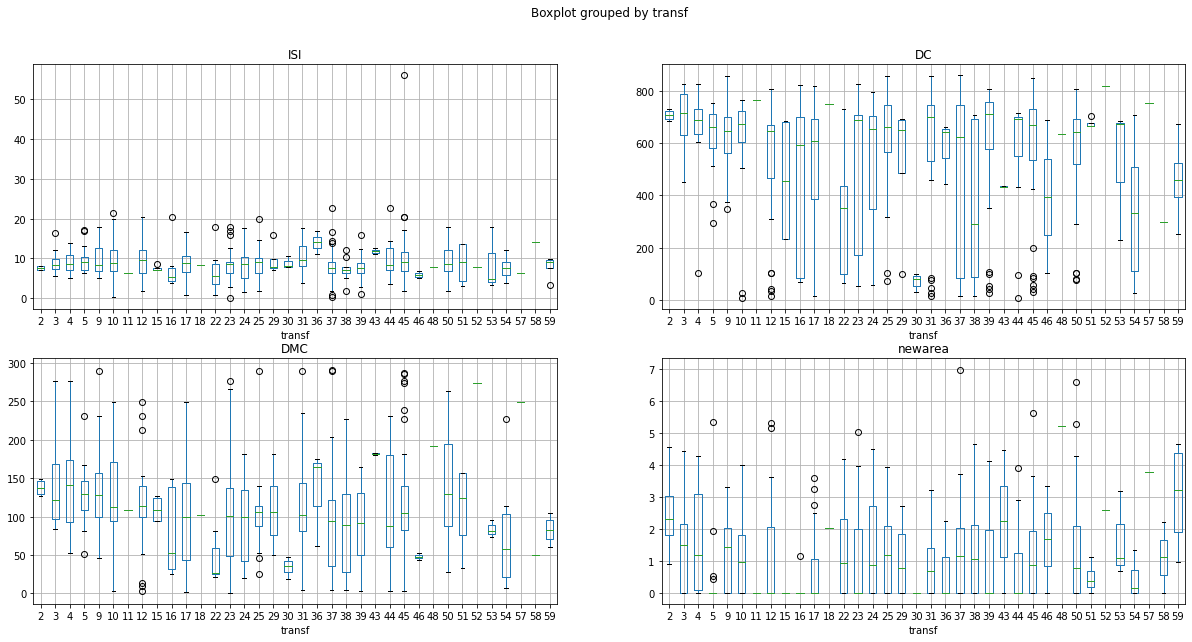

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(20,10))
pl = lambda s,i: df.boxplot(column = [s], by='transf', ax = ax1[i])
pl2 = lambda s,i: df.boxplot(column = [s], by='transf', ax = ax2[i])
list(map(lambda x,y: pl(x,y),variables[0:2],range(2)))
list(map(lambda x,y: pl2(x,y),variables[2:],range(2)));

### Pruebas multiestadistico de Correción o Pruebas Post Hoc

Para ver en que grupos la prueba de Kruskal-Wallis falla se puede hacer las pruebas multiestadistico de correción. Una de las pruebas más comunes que se usa es el Test de Holm o también conocida como Bonferroni-Holm. En ella se orden ascendentemente todos los p-value. Se compara el p-value con el alfa dividido entre el número de muestras, en el caso de que el p-value sea menor se detiene el proceso y por tanto se rechaza la comparación, se pasa al siguiente p-value y se compará con el alfa menos uno. El proceso se repite hasta detenerse cuando la comparación ya no sea significativa. En la siguiente imagén se puede visualizar de mejor manera el funcionamiento de la prueba.
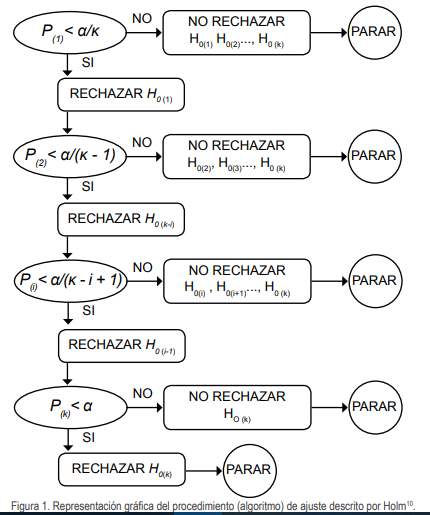

In [12]:
def Holm(k: 'lista con los p_value', alpha:'valor alpha',
         comb: 'lista de combinaciones'):
    arr = multipletests(k, alpha = alpha,method = 'holm')[0]
    if True in arr:
        print('Se encontraron los siguientes valores que no cumplen con el',
             'alpha del la prueba')
        return [comb[i] for i in range(len(arr))  if (arr[i] == True)]
    else:
        print('No se encontraron conjuntos de valores que no pasen el Test')

In [12]:
l = [np.array(i) for i in df.groupby('transf')['DMC'].apply(list).tolist()]

In [13]:
comb = list(itertools.combinations(range(36), 2))
l = [np.array(i) for i in df.groupby('transf')['DMC'].apply(list).tolist()]
k = [st.kruskal(l[i[0]],l[i[1]])[1] for i in comb]
Holm(k,alpha,comb)

No se encontraron conjuntos de valores que no pasen el Test


Como no hay un resultado positivo en las prueba de correcion de Holm entonces se acepta la hipotesis nula de que las muestras tienen la misma media por lo que el coeficiente DMC es independiente de la zona donde se genera el valor

En base a todas las pruebas realizadas anteriormente se pueden confirmar las hipotesis de que los indices ISI, DC y DMC además del area quemada son independientes de la zona donde se generan.

## Independencia del mes

In [13]:
def test_lk_12(s:'lista que contienen los vectores con los grupos', 
              stri: 'Nombre de la variable a analizar',alpha: 'valor de alpha de aceptación'):
    '''
    Esta es una función para llevar a cabo las pruebas de Levene para ver si los grupos de variables continuas tienen
    la misma varianza y la prueba de Kruskal para ver si los grupos de variables continuas tienen la misma media y 
    provienen de la misma distribución
    ---
    Esta prueba es para 36 grupos
    ---
    ---
    Devuelve los resultados de las pruebas tomando en consideración un alpha de aceptación para comparar con el p-value
    de las pruebas
    '''
    lev = st.levene(s[0],s[1],s[2],s[3],s[4],s[5],s[6],s[7],s[8],s[9],s[10],s[11])
    
    print('Test para ',stri)
    
    if lev[1] > alpha:
        print('No se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de ',lev[1])
        
        krus = st.kruskal(s[0],s[1],s[2],s[3],s[4],s[5],s[6],s[7],s[8],s[9],s[10],s[11])
        
        if krus[1] > alpha:
            print('No se rechaza la Hipotesis Nula del test de Kruskal-Wallis. Se obtuvo un p-value de ',krus[1])
        else:
            print('Se rechaza la Hipotesis Nula del test de Kruskal-Wallis. Se obtuvo un p-value de ',krus[1])
    else:
        print('Se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de ',lev[1],
              'Por tanto el test de Kruskal-Wallis no se puede realizar')

In [14]:
alle2 = [[np.array(i) for i in df.groupby('month')[var].apply(list).tolist()] for var in variables]
list(map(lambda x,y: test_lk_12(x,y,alpha),alle2,variables));

Test para  ISI
Se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de  6.419049105390486e-07 Por tanto el test de Kruskal-Wallis no se puede realizar
Test para  DC
Se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de  7.682596797548698e-08 Por tanto el test de Kruskal-Wallis no se puede realizar
Test para  DMC
Se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de  1.4554211878711579e-12 Por tanto el test de Kruskal-Wallis no se puede realizar
Test para  newarea
No se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de  0.13547187378035694
No se rechaza la Hipotesis Nula del test de Kruskal-Wallis. Se obtuvo un p-value de  0.013955143672609737


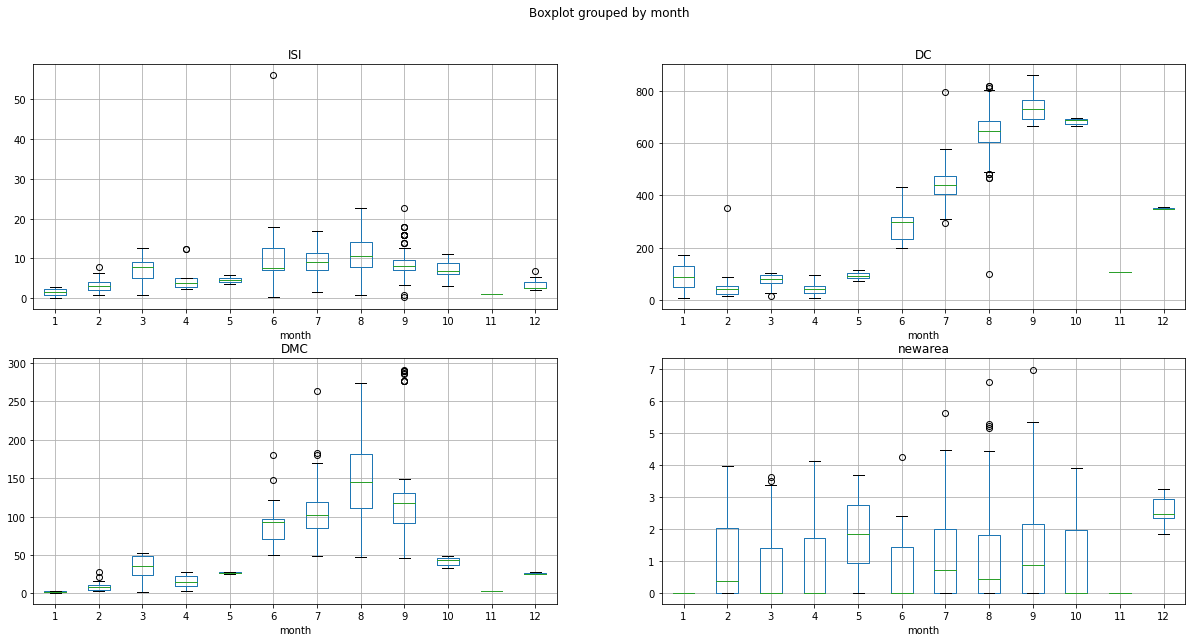

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(20,10))
pl = lambda s,i: df.boxplot(column = [s], by='month', ax = ax1[i])
pl2 = lambda s,i: df.boxplot(column = [s], by='month', ax = ax2[i])
list(map(lambda x,y: pl(x,y),variables[0:2],range(2)))
list(map(lambda x,y: pl2(x,y),variables[2:],range(2)));

Como se puede observar en los boxplot de los datos observados las distribuciones de los indices varían conforme avanzan los meses, sobre todo el DC y el DMC cambian debido a las lluvias en verano, en el caso del ISI se puede observar es menor que el DC y el DMC pero a pesar de eso el p-value sigue siendo muy bajo, cuando se consideran solamente los meses de verano se mejorá aun más el p-value aunque sigue siendo menor a un alfa de 0.01 lo cuál ya es bajo. Para el caso del area quemada es independiente del mes en el que inicia el incendio.

En los casos de DC, ISI y DMC se realiza la prueba de Holm para ver que distribuciones no tienen parecido además de que se ofrecen histogramas para poder compararlos más facilmente y corroborar los resultados de Holm

In [16]:
def test_lk_4(s:'lista que contienen los vectores con los grupos', 
              stri: 'Nombre de la variable a analizar',alpha: 'valor de alpha de aceptación'):
    '''
    Esta es una función para llevar a cabo las pruebas de Levene para ver si los grupos de variables continuas tienen
    la misma varianza y la prueba de Kruskal para ver si los grupos de variables continuas tienen la misma media y 
    provienen de la misma distribución
    ---
    Esta prueba es para 36 grupos
    ---
    ---
    Devuelve los resultados de las pruebas tomando en consideración un alpha de aceptación para comparar con el p-value
    de las pruebas
    '''
    lev = st.levene(s[5],s[6],s[7],s[8])
    
    print('Test para ',stri)
    
    if lev[1] > alpha:
        print('No se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de ',lev[1])
        
        krus = st.kruskal(s[5],s[6],s[7],s[8])
    
        if krus[1] > alpha:
            print('No se rechaza la Hipotesis Nula del test de Kruskal-Wallis. Se obtuvo un p-value de ',krus[1])
        else:
            print('Se rechaza la Hipotesis Nula del test de Kruskal-Wallis. Se obtuvo un p-value de ',krus[1])
    else:
        print('Se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de ',lev[1],
              'Por tanto el test de Kruskal-Wallis no se puede realizar')

In [15]:
def comp_hist(s: 'lista de variables a plotear', t: 'subtitulos', c:'color'):
    fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(20,10))
    pl = lambda s,i: sns.histplot(data=s, stat='density',
                                  color=c, bins=5,ax = ax1[i])
    pl2 = lambda s,i: sns.histplot(data=s, stat='density',
                                  color=c, bins=5,ax = ax2[i])
    titles = lambda t,i: ax1[i].title.set_text(t)
    titles2 = lambda t,i: ax2[i].title.set_text(t)
    list(map(lambda x,y: pl(x,y),s[0:2],range(2)))
    list(map(lambda x,y: pl2(x,y),s[2:],range(2)))
    list(map(lambda x,y: titles(x,y),t[0:2],range(2)))
    list(map(lambda x,y: titles2(x,y),t[2:],range(2)))
    plt.show()

In [19]:
list(map(lambda x,y: test_lk_4(x,y,alpha),alle2,variables));

Test para  ISI
Se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de  7.284858920043467e-07 Por tanto el test de Kruskal-Wallis no se puede realizar
Test para  DC
Se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de  0.004942823789306379 Por tanto el test de Kruskal-Wallis no se puede realizar
Test para  DMC
Se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de  0.004026601302928546 Por tanto el test de Kruskal-Wallis no se puede realizar
Test para  newarea
No se rechaza la Hipotesis Nula del test de Levene. Se obtuvo un p-value de  0.2809895481447168
No se rechaza la Hipotesis Nula del test de Kruskal-Wallis. Se obtuvo un p-value de  0.5176953715307313


In [16]:
meses = ['Junio-5','Julio-6','Agosto-7','Septiembre-8']

In [17]:
comb_k = list(itertools.combinations(range(5,9), 2))

In [18]:
sm_isi = alle2[0]
ksm_isi = [st.kruskal(sm_isi[i[0]],sm_isi[i[1]])[1] for i in comb_k]
Holm(ksm_isi,alpha,comb_k)

Se encontraron los siguientes valores que no cumplen con el alpha del la prueba


[(7, 8)]

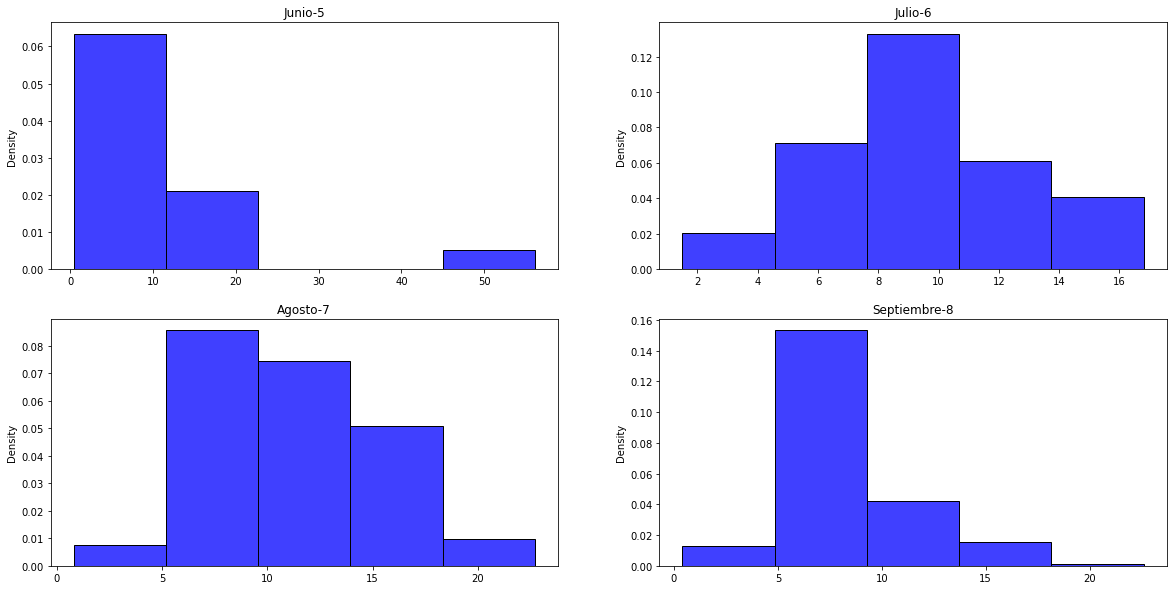

In [19]:
isi_his = sm_isi[5:9]
comp_hist(isi_his,meses,'b')

In [20]:
sm_dc = alle2[1]
ksm_dc = [st.kruskal(sm_dc[i[0]],sm_dc[i[1]])[1] for i in comb_k]
Holm(ksm_dc,alpha,comb_k)

Se encontraron los siguientes valores que no cumplen con el alpha del la prueba


[(5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (7, 8)]

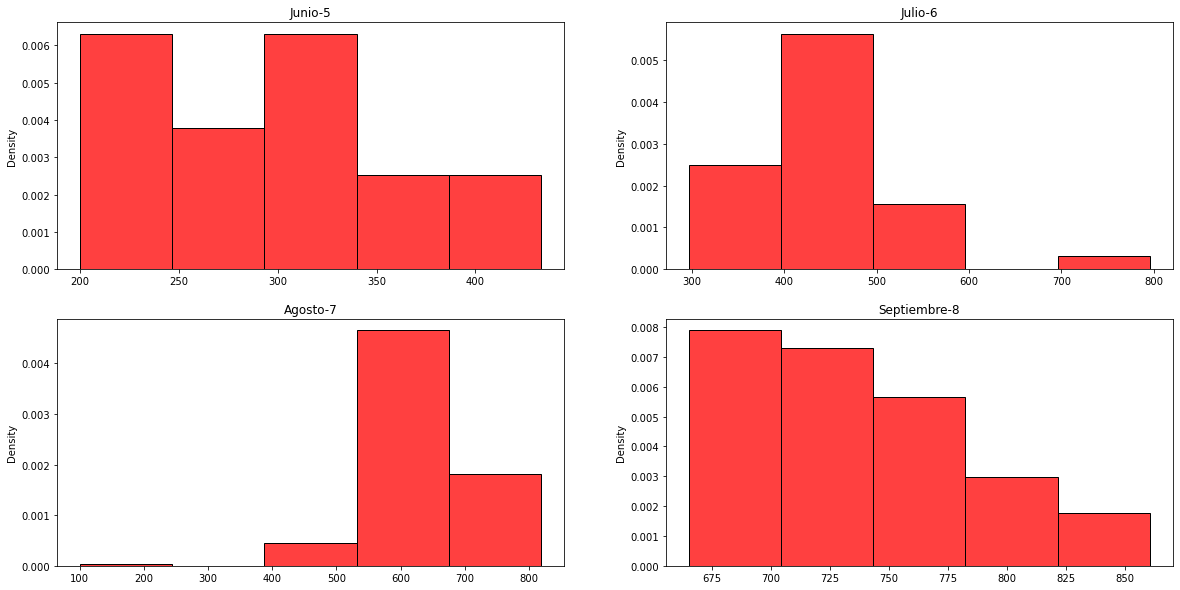

In [21]:
dc_his = sm_dc[5:9]
comp_hist(dc_his,meses,'r')

In [22]:
sm_dmc = alle2[2]
ksm_dmc = [st.kruskal(sm_dmc[i[0]],sm_dmc[i[1]])[1] for i in comb_k]
Holm(ksm_dmc,alpha,comb_k)

Se encontraron los siguientes valores que no cumplen con el alpha del la prueba


[(5, 7), (6, 7), (7, 8)]

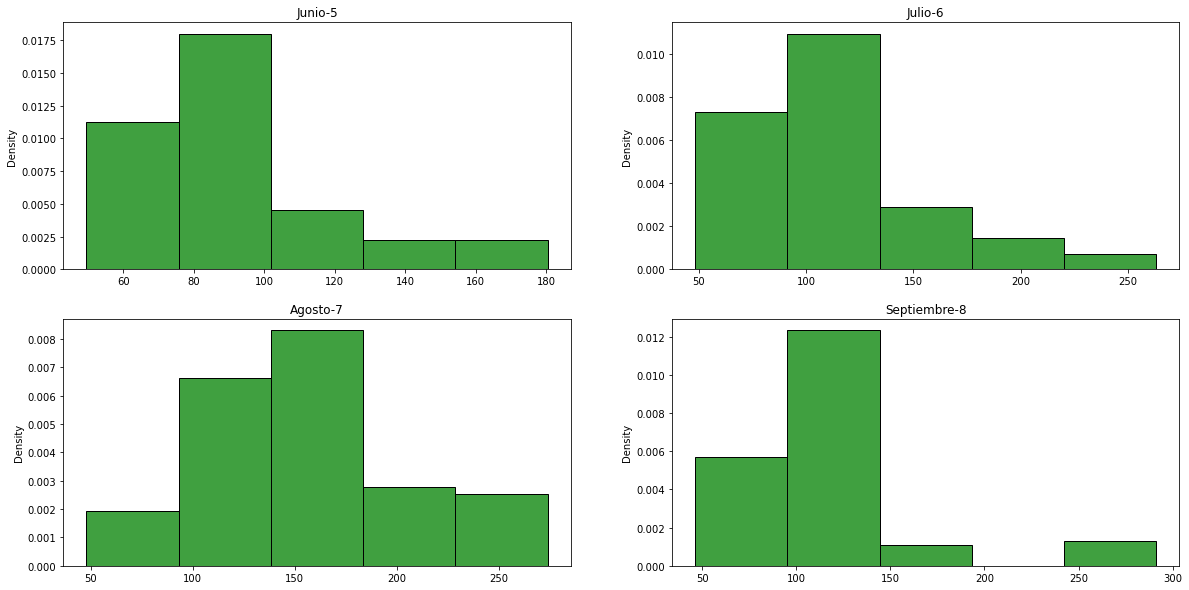

In [23]:
dmc_his = sm_dmc[5:9]
comp_hist(dmc_his,meses,'g')

### Funciones KDE

In [509]:
def KDE_est(x: 'array con los datos'):
    if len(x) < 20:
        cc = 10
    else:
        cc = 20
    grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 100.0, 200)},
                    cv=cc) # 20-fold cross-validation
    grid.fit(x[:, None])
    ban = grid.best_params_
    ban = ban['bandwidth']
    x_grid = np.linspace(x.min(), x.max(), 1000)
    kde_sklearn = KernelDensity(bandwidth = ban, kernel = 'gaussian').fit(x[:,np.newaxis])
    f_skle = lambda x: np.exp(kde_sklearn.score_samples(x[:, np.newaxis]))
    return f_skle,kde_sklearn

In [29]:
def KDE_plot(x: 'array con los datos', fpdf: 'Función con el kde', title: 'titulo'):
    x_grid = np.linspace(x.min(), x.max(), 1000)
    plt.plot(x_grid, fpdf(x_grid))
    plt.hist(x,bins = 5, density = True, color = '#0D3D63')
    plt.title('ISI KDE')
    plt.show()

In [25]:
def KDE_plot2(x: 'array con los datos', fpdf: 'Función con el kde', title: 'titulo', ax:'axis donde graficar',
             c = 'color'):
    x_grid = np.linspace(x.min(), x.max(), 1000)
    y = fpdf(x_grid)
    v = pd.DataFrame(data = y, index = x_grid)
    v.plot(ax = ax)
    k = pd.DataFrame(data = x)
    k.hist(bins = 5, density = True, ax = ax, color = c)
    ax.title.set_text(title)

In [513]:
ex_isis = [KDE_est(i) for i in isi_his]
ex_dcs = [KDE_est(i) for i in dc_his]
ex_dmcs = [KDE_est(i) for i in dmc_his]

In [514]:
ex_dc = [ex_dcs[i][0] for i in range(len(ex_dcs))]
ex_dck = [ex_dcs[i][1] for i in range(len(ex_dcs))]
ex_isi = [ex_isis[i][0] for i in range(len(ex_isis))]
ex_isik = [ex_isis[i][1] for i in range(len(ex_isis))]
ex_dmc = [ex_dmcs[i][0] for i in range(len(ex_dmcs))]
ex_dmck = [ex_dmcs[i][1] for i in range(len(ex_dmcs))]

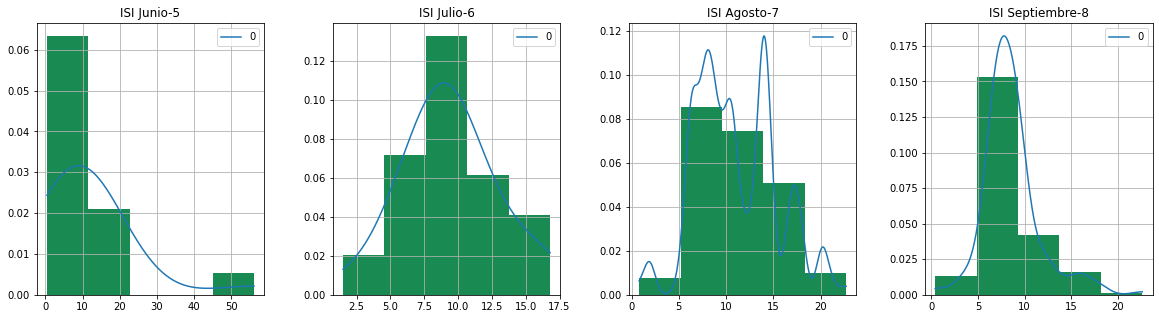

In [30]:
fig, ax = plt.subplots(1,4, figsize = [20,5])
[KDE_plot2(isi_his[i],ex_isi[i], 'ISI '+meses[i], ax = ax[i], c='#198B52') for i in range(4)];

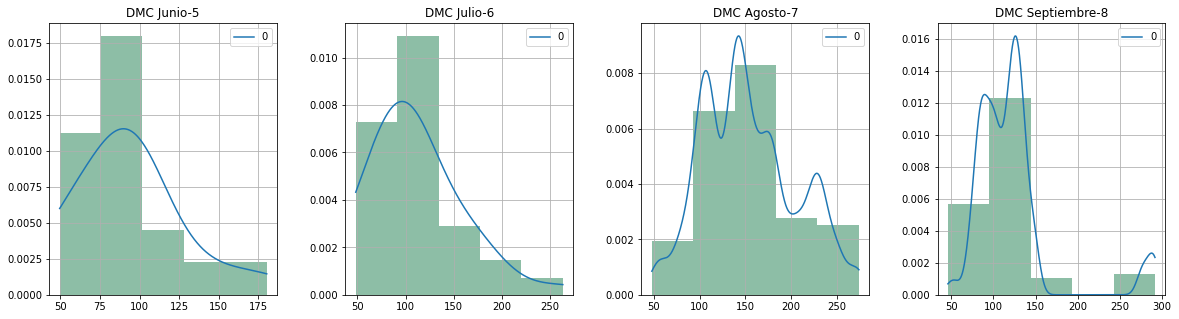

In [31]:
fig, ax = plt.subplots(1,4, figsize = [20,5])
[KDE_plot2(dmc_his[i],ex_dmc[i], 'DMC '+meses[i], ax = ax[i], c= '#8DBEA6') for i in range(4)];

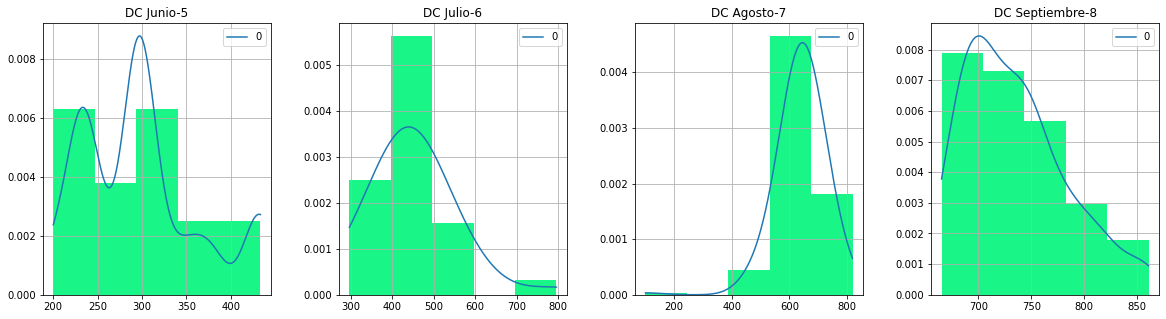

In [27]:
fig, ax = plt.subplots(1,4, figsize = [20,5])
[KDE_plot2(dc_his[i],ex_dc[i], 'DC '+meses[i], ax = ax[i], c= '#1AF587') for i in range(4)];

## Transformaciones a los datos

In [28]:
pt_dc5 = PowerTransformer(method = 'box-cox')
pt_dc5.fit(dc_his[0].reshape(-1,1))
trans_dc5 = pt_dc5.transform(dc_his[0].reshape(-1,1))

In [29]:
pt_dc6 = PowerTransformer(method = 'box-cox')
pt_dc6.fit(dc_his[1].reshape(-1,1))
trans_dc6 = pt_dc6.transform(dc_his[1].reshape(-1,1))

In [502]:
pt_dc7 = PowerTransformer(method = 'box-cox')
pt_dc7.fit(dc_his[2].reshape(-1,1))
trans_dc7 = pt_dc7.transform(dc_his[2].reshape(-1,1))

In [187]:
pt_dc8 = PowerTransformer(method = 'box-cox')
pt_dc8.fit(dc_his[3].reshape(-1,1))
trans_dc8 = pt_dc8.transform(dc_his[3].reshape(-1,1))

In [189]:
dc_trans = [trans_dc5.reshape(len(trans_dc5)),trans_dc6.reshape(len(trans_dc6)),trans_dc7.reshape(len(trans_dc7)),
           trans_dc8.reshape(len(trans_dc8))]
ex_dct = [KDE_est(i) for i in dc_trans]

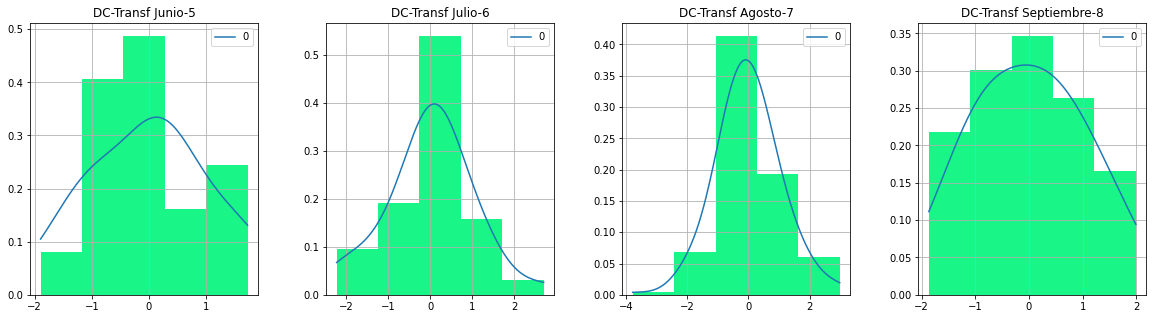

In [190]:
fig, ax = plt.subplots(1,4, figsize = [20,5])
[KDE_plot2(dc_trans[i],ex_dct[i], 'DC-Transf '+meses[i], ax = ax[i], c= '#1AF587') for i in range(4)];

# Ajuste de distribuciones continuas a los datos mensuales de DC

In [25]:
f = Fitter(dc_his[0], bins = 5)
f.fit()

C:\Users\flavi\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1715: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
C:\Users\flavi\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1715: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


In [44]:
f1 = Fitter(dc_his[1], bins = 5)
f1.fit()

Wall time: 0 ns


C:\Users\flavi\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1715: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
C:\Users\flavi\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1715: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
C:\Users\flavi\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1715: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determi

In [45]:
f2 = Fitter(dc_his[2], bins = 5)
f2.fit()

Wall time: 0 ns


C:\Users\flavi\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1715: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
C:\Users\flavi\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1715: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


In [389]:
f3 = Fitter(dc_his[3], bins = 5)
f3.fit()

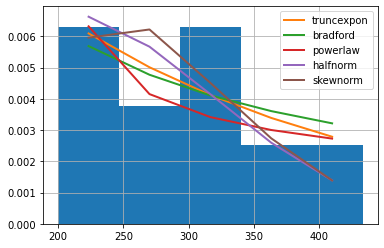

In [26]:
s = f.summary()
best = s.head(4).index.values

C:\Users\flavi\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:4523: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


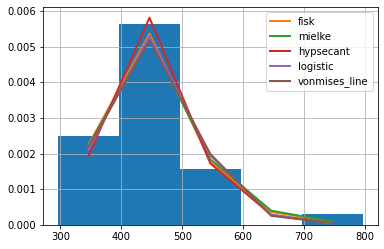

In [47]:
s1 = f1.summary()
best1 = s1.head(4).index.values

C:\Users\flavi\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:4523: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


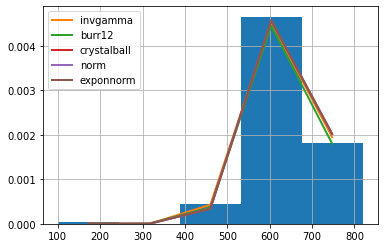

In [52]:
s2 = f2.summary()
best2 = s2.head(4).index.values

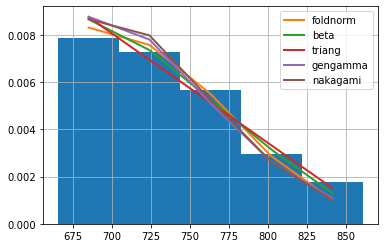

In [402]:
s3 = f3.summary()
best3 = s3.head(4).index.values

In [45]:
def qq4(data:'datos a evaluar',best:'mejores resultados'):
    fig, ax = plt.subplots(1,4, figsize = [20,9])
    [sm.qqplot(data, dist=getattr(st, best[i]), line='q', fit=True, ax=ax[i]) for i in range(4)]
    fig.suptitle('Q-Q Test')
    plt.show()

In [63]:
import warnings
warnings.filterwarnings("ignore")

In [70]:
import winsound

In [71]:
def alerta():
    d1 = 500
    d2 = 200
    f1 = 330
    f2 = 261
    winsound.Beep(f1, d1)
    winsound.Beep(f2, d2)
    winsound.Beep(f1, d1)

### Transformaciones Ajustes

In [64]:
ft5 = Fitter(dc_trans[0], bins = 5)
ft5.fit()

In [65]:
ft6 = Fitter(dc_trans[1], bins = 5)
ft6.fit()

In [66]:
ft7 = Fitter(dc_trans[2], bins = 5)
ft7.fit()

In [191]:
ft8 = Fitter(dc_trans[3], bins = 5)
ft8.fit()

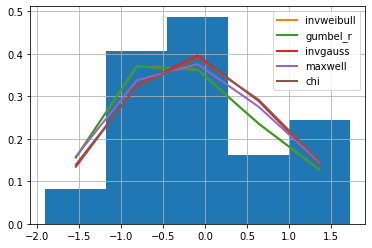

In [67]:
st5 = ft5.summary()
bestt5 = st5.head(4).index.values

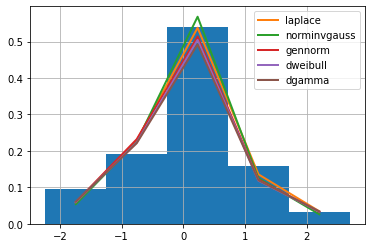

In [73]:
st6 = ft6.summary()
bestt6 = st6.head(4).index.values

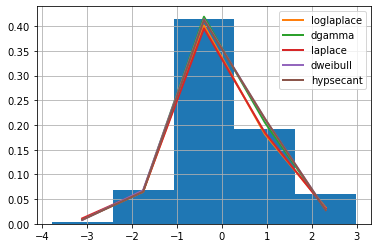

In [380]:
st7 = ft7.summary()
bestt7 = st7.head(4).index.values

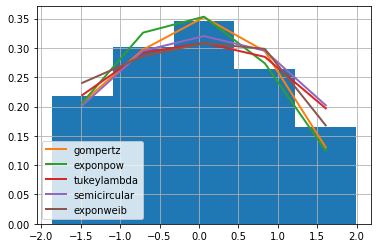

In [194]:
st8 = ft8.summary()
bestt8 = st8.head(4).index.values

## Test visual QQ

### Junio

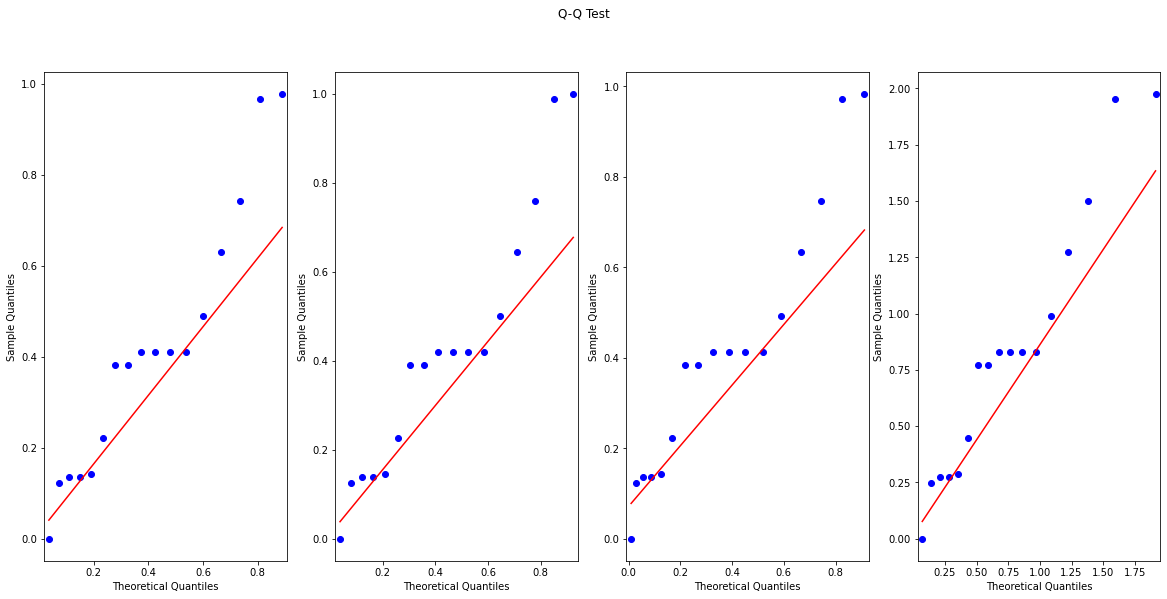

In [28]:
qq4(dc_his[0],best)

Se puede observar como la poca cantidad de datos no permite que se ajusten adecuadamente las distribuciones y los mejores resultados obtenidos por la paquetería fitter no se adaptan adecuadamente para el mes de Junio en el caso del indicador DMC

### Julio

C:\Users\flavi\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:4523: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


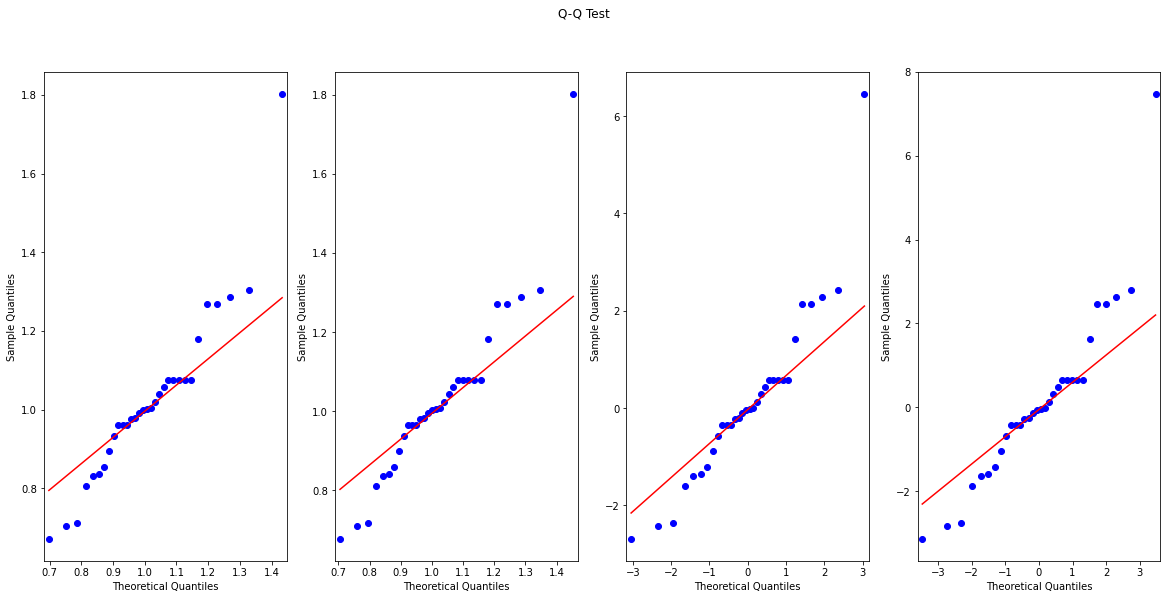

In [48]:
qq4(dc_his[1],best1)

Para el mes de Julio igual para el caso del DMC sucede algo similar y los datos no se ajustan adecuadamente, sosbre todo se observa una alta asímetría hacia la derecha en los datos donde se alejan demasiado haciael final de la curva QQ

### Agosto

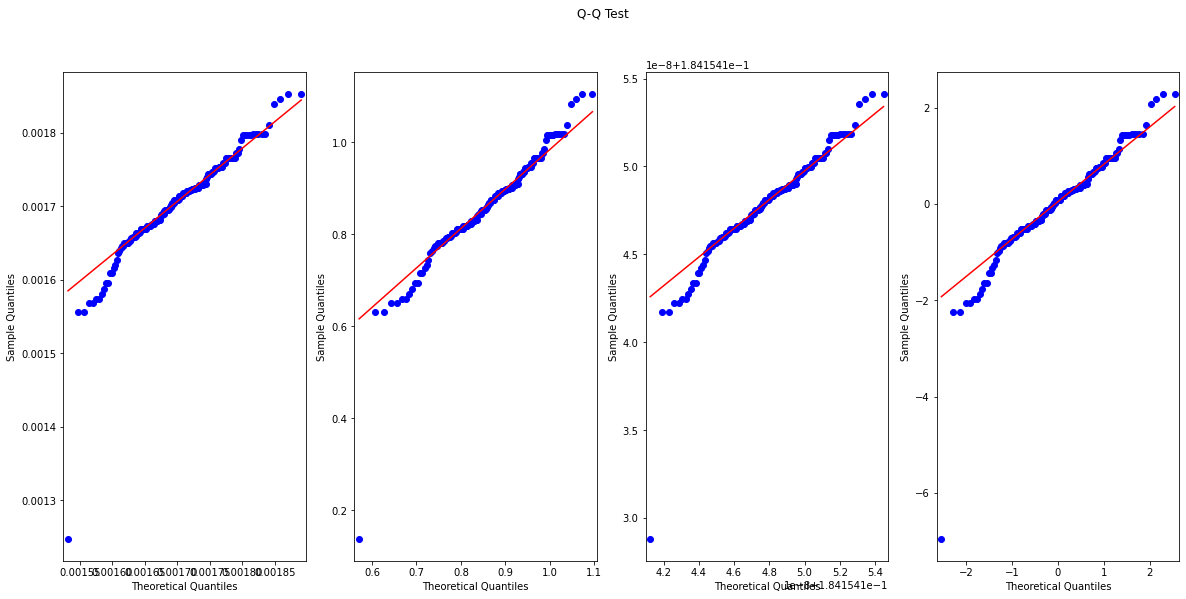

In [98]:
qq4(dc_his[2],best2)

En el penultimo mes para la todas las distribuciones que más se aproximaban con el algoritmo de la paquetería fitter se puede observar que tienen un comportamiento de leptokurtosis o colas gruesas sobre todo al principio donde se ve un comportamiento más asimpotico podría acercarse mejor la aproximación a traves del KDE para generar las varibles aleatorias

### Septiembre

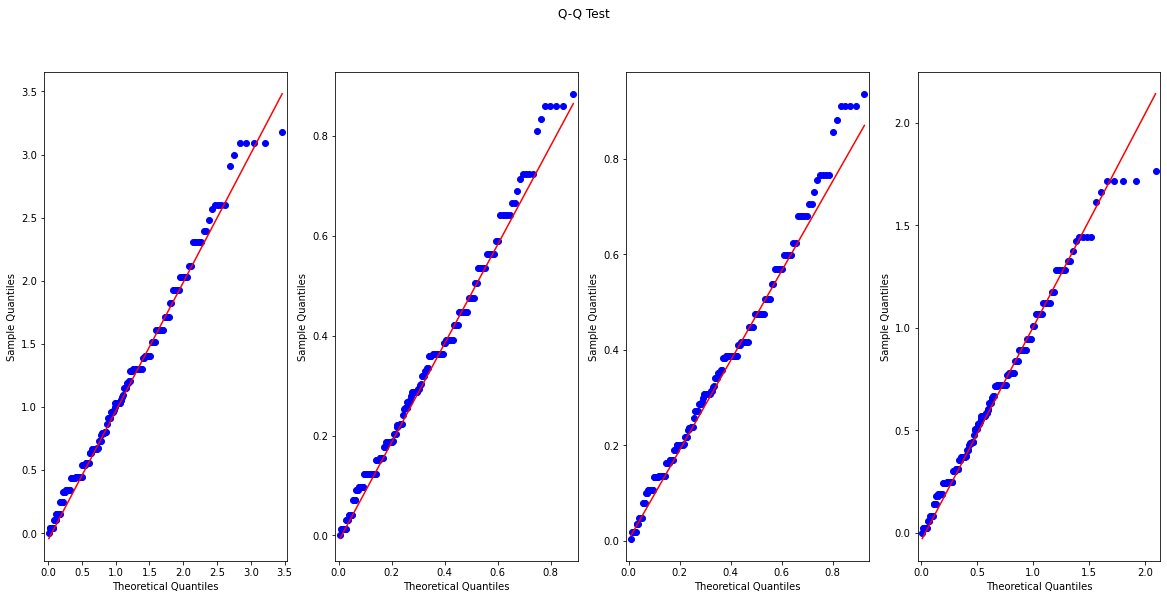

In [391]:
qq4(dc_his[3],best3)

In [392]:
best3

array(['foldnorm', 'beta', 'triang', 'gengamma'], dtype=object)

El comportamiento en la mayoría de las distribuciones se asemeja la mayor parte del tiempo en la grafica, la que se observa que tiene una mayor aproximación es la segunda o la tercera grafica que corresponde a las distribuciones beta y triangular respectivamente, si bien presentan una ligera asimetría a la derecha sobre los últimos datos se podrá corroborar más adelante el ajuste con los Test de Bondad de Ajuste de Chi cuadrado y el Test de Kolmogorov-Smirnov

### Transformaciones

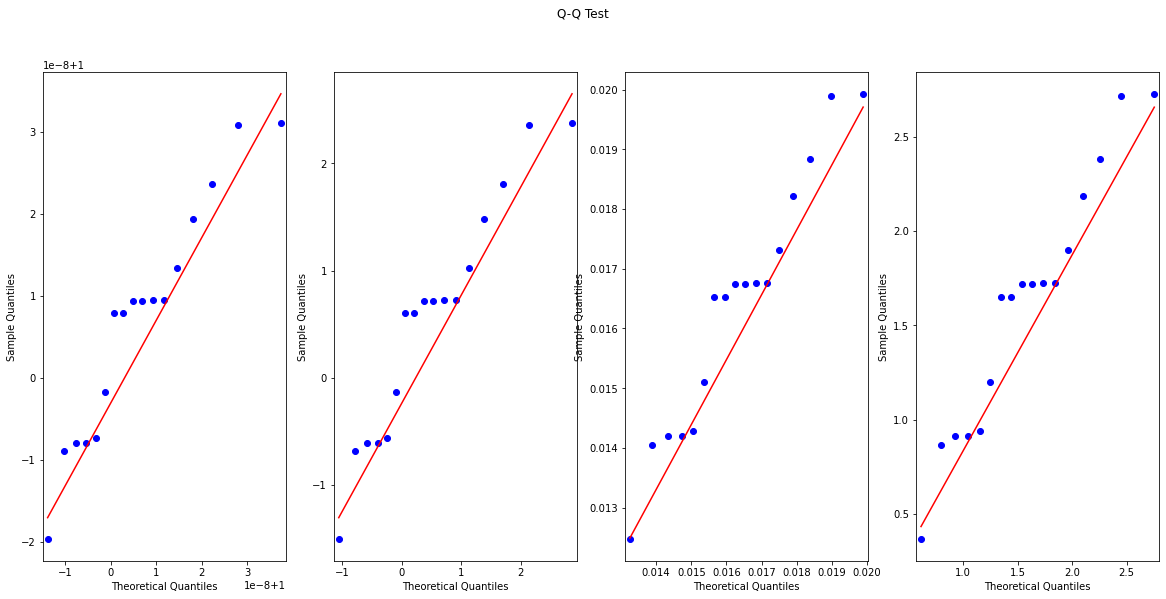

In [77]:
qq4(dc_trans[0],bestt5)

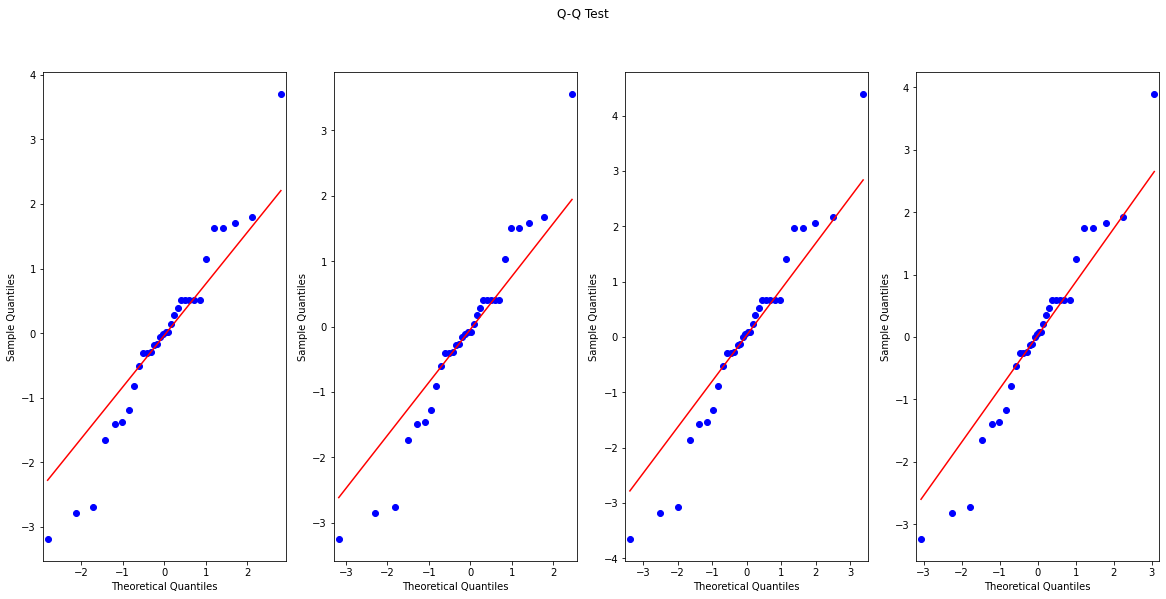

In [76]:
qq4(dc_trans[1],bestt6)

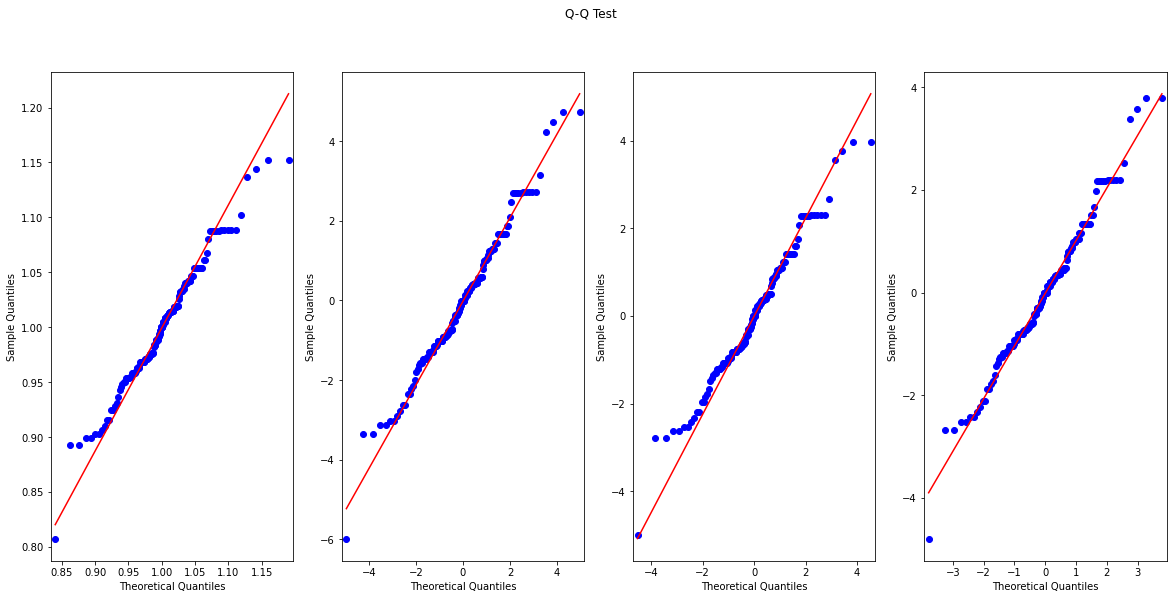

In [75]:
qq4(dc_trans[2],bestt7)

In [381]:
bestt7

array(['loglaplace', 'dgamma', 'laplace', 'dweibull'], dtype=object)

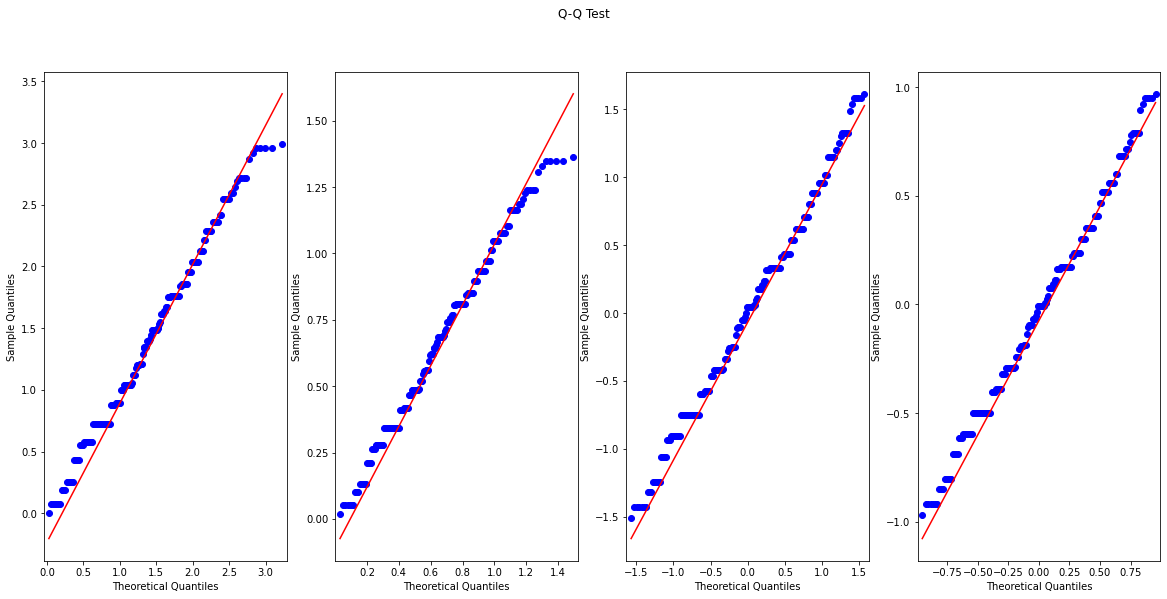

In [195]:
qq4(dc_trans[3],bestt8)

In [196]:
bestt8

array(['gompertz', 'exponpow', 'tukeylambda', 'semicircular'],
      dtype=object)

Como se puede observar si bien las transformaciones de potencia mejoran visualmente los resultados en cuanto al histograma o a la apariencia del KDE (en cuanto a hacerlo parecer más como una normal) se puede observar que en la prueba QQ el ajustarlo a una determinada función de distribución de probabilidad resulta que los datos no se ajustan adecuadamente, se rechaza por completo que se ajusten a las funciones y ni siquiera se procede a realizar Test de Kolmogorov-Smirnof o Prueba de Bondad de Ajuste

## Test de Chi cuadrado y KS

In [374]:
def testKS(x,dist,parm, alpha):
    s = st.kstest(x,dist,parm)
    print('Test de Kolmogorov- Smirnov para la distribución ',dist)
    print('Resultado del test: estadistico: ',s[0],'p-value',s[1])
    if s[1] > alpha:
        print('No se rechaza la hipotesis nula')
    else:
        print('Se rechaza la hipotesis nula los datos no se ajustan a la distribución')

In [363]:
def Bondad_ajuste(X,J,dist,params, alpha):
    y, x = np.histogram(X, bins = J, density=True)
    x = abs(x[:-1])
    pi = getattr(st, dist).pdf(x, *params)
    Ei = x*pi
    X2 = st.chisquare(y, Ei)
    print('Test para la distribución', dist)
    print('Resultado del test:  chi=', X2[0], 'p-value=', X2[1])
    if X2[1] > alpha:
        print('No se rechaza la hipotesis nula')
    else:
        print('Se rechaza la hipotesis nula los datos no se ajustan a la distribución')
    x2 = np.sum(list(map(lambda Ei, obs_i:(obs_i - Ei)**2 / Ei, Ei, y)))

### Septiembre sin transformación

### Estimación de los parametros

In [403]:
best3 = best3[1:3]

In [404]:
dc7p = [getattr(st, d).fit(dc_his[3]) for d in best3]

### Test de Kolmogorov - Smirnov

In [405]:
[testKS(dc_his[3],best3[i],dc7p[i], alpha) for i in range(2)];

Test de Kolmogorov- Smirnov para la distribución  beta
Resultado del test: estadistico:  0.055447470443834135 p-value 0.6449272857307404
No se rechaza la hipotesis nula
Test de Kolmogorov- Smirnov para la distribución  triang
Resultado del test: estadistico:  0.06688263949295961 p-value 0.4072287733207287
No se rechaza la hipotesis nula


### Test de Bondad de Ajuste de $\chi$ cuadrada

In [406]:
[Bondad_ajuste(X = dc_his[3],J = 10,dist = best3[i], params= dc7p[i], alpha = 0.01) for i in range(2)];

Test para la distribución beta
Resultado del test:  chi= 37.63834816528379 p-value= 2.0237187267655558e-05
Se rechaza la hipotesis nula los datos no se ajustan a la distribución
Test para la distribución triang
Resultado del test:  chi= 35.75939945794465 p-value= 4.373897943120757e-05
Se rechaza la hipotesis nula los datos no se ajustan a la distribución


### Agosto Transformado

In [382]:
bestt7 = bestt7[1:]

In [383]:
dc7tp = [getattr(st, d).fit(dc_trans[2]) for d in bestt7]

### Prueba KS

In [384]:
[testKS(dc_trans[2],bestt7[i],dc7tp[i], alpha) for i in range(3)];

Test de Kolmogorov- Smirnov para la distribución  dgamma
Resultado del test: estadistico:  0.07281982514976276 p-value 0.27003121891742465
No se rechaza la hipotesis nula
Test de Kolmogorov- Smirnov para la distribución  laplace
Resultado del test: estadistico:  0.08418122206694256 p-value 0.13915451724386663
No se rechaza la hipotesis nula
Test de Kolmogorov- Smirnov para la distribución  dweibull
Resultado del test: estadistico:  0.06806419815225112 p-value 0.3457733301191458
No se rechaza la hipotesis nula


### Bondad de ajuste

In [385]:
[Bondad_ajuste(X = dc_trans[2],J = 10,dist = bestt7[i], params= dc7tp[i], alpha = 0.01) for i in range(3)];

Test para la distribución dgamma
Resultado del test:  chi= 0.9779618676783751 p-value= 0.9994866328946053
No se rechaza la hipotesis nula
Test para la distribución laplace
Resultado del test:  chi= 1.1414323254215109 p-value= 0.9990363656223706
No se rechaza la hipotesis nula
Test para la distribución dweibull
Resultado del test:  chi= 0.9854960613848309 p-value= 0.9994702060424548
No se rechaza la hipotesis nula


### Septiembre transformado

In [364]:
bestt8 = bestt8[2:]

In [365]:
dc8tp = [getattr(st, d).fit(dc_trans[3]) for d in bestt8]

### Prueba KS

In [375]:
[testKS(dc_trans[3],bestt8[i],dc8tp[i], alpha) for i in range(2)];

Test de Kolmogorov- Smirnov para la distribución  tukeylambda
Resultado del test: estadistico:  0.05448852939551049 p-value 0.6661629490797402
No se rechaza la hipotesis nula
Test de Kolmogorov- Smirnov para la distribución  semicircular
Resultado del test: estadistico:  0.0666136318878845 p-value 0.4122316821673522
No se rechaza la hipotesis nula


### Bondad de ajuste

In [368]:
[Bondad_ajuste(X = dc_trans[3],J = 10,dist = bestt8[i], params= dc8tp[i], alpha = 0.01) for i in range(2)];

Test para la distribución tukeylambda
Resultado del test:  chi= 6.899625830230434 p-value= 0.6475690807078045
No se rechaza la hipotesis nula
Test para la distribución semicircular
Resultado del test:  chi= 6.610751684847148 p-value= 0.677572774555515
No se rechaza la hipotesis nula


## Comparación de predicción

### Funciones de error

In [350]:
### Funciones de error

RMSE = lambda x,x_hat:(((x - x_hat)**2).mean())**0.5
MAPE = lambda x,x_hat: (abs((x - x_hat)/x)).mean()
MSE = lambda x,x_hat:((x - x_hat)**2).mean()
MAE = lambda x,x_hat: abs((x-x_hat)).mean()
functions = [RMSE,MAPE,MSE,MAE]

In [342]:
def comparar(X,J,dist,params, kde):
    y, x = np.histogram(X, bins = J, density=True)
    x = x[1:]
    pi = list(map(lambda d,pp: getattr(st, d).pdf(x, *pp),dist,params))
    Ei = list(map(lambda p:x*p,pi))
    ki = kde(x)
    idx = ['kde']+dist
    values = [ki]+pi
    s = [[functions[i](values[j],y)for i in  range(4)] for j in range(len(values))]
    df = pd.DataFrame(data = s,index = idx, columns = ['RMSE','MAPE','MSE','MAE'])
    dp = pd.DataFrame(data = np.array(values).T, index = x, columns = idx)
    dp['real'] = y
    dp.plot()
    return df

In [295]:
distrib1 = ["dgamma","laplace","dweibull"]
parame1 = [params1,params2,params3]

,RMSE,MAPE,MSE,MAE
kde,0.052537,0.235881,0.002760,0.045822
tukeylambda,0.058010,0.340251,0.003365,0.046119
semicircular,0.053641,0.262254,0.002877,0.045432


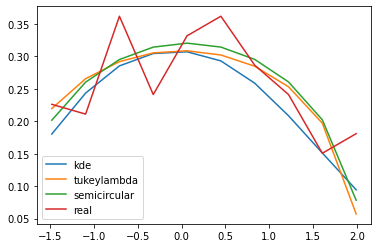

In [348]:
comparar(dc_trans[3], 10, distrib, parame,ex_dct[3])

Se puede observar que en todas las metricas el KDE se aproxima de mejor manera a los datos reales por lo que será la función que se utilizará para modelar los datos

In [228]:
distrib = ["tukeylambda","semicircular"]
parame = [params4,params5]

,RMSE,MAPE,MSE,MAE
kde,0.063621,0.442057,0.004048,0.046885
dgamma,0.049447,0.666405,0.002445,0.037558
laplace,0.048946,0.617863,0.002396,0.034430
dweibull,0.048830,0.695287,0.002384,0.035792


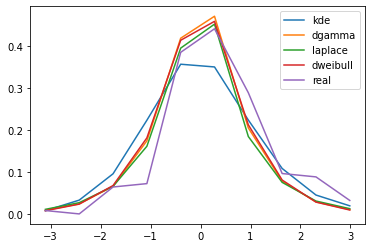

In [349]:
comparar(dc_trans[2], 10, distrib1, parame1,ex_dct[2])

Se puede observar que en este caso las funciones de Laplace y de Doble de Weibull son las que mejor se aproximan a los datos reales, dado que las metricas le dan la ventaja a una sobre la otra en la misma proporción se tomará entonces en cuenta a los resultados de la prueba de bondad de ajuste y el Test de Kolmogorov Smirnov 

## Simulación de los meses para cada nodo

In [440]:
def estratificado(N:'Número de variables a generar'):
    """
    Función que devuelve un vector de longitud N con variables aleatorias distribuidas uniformemente y utilizando
    el método de reducción de la varianza por estratificación
    """
    vec = np.random.rand(N)
    aux = np.arange(0,N)
    return (vec + aux)/N

In [439]:
def uniformestra(N:'Número de variables a generar', mini:'Minimo',maxi:'Maximo'):
    """
    Función que devuelve un vector de longitud N con variables aleatorias distribuidas uniformemente y utilizando
    el método de reducción de la varianza por estratificación
    """
    esp = (maxi - mini)/N
    vec = np.random.rand(N)*esp
    aux = np.linspace(mini,maxi,N)
    return (aux+vec)

In [441]:
def Acep_rechazo(R:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar',
                 t:'función que mayora a f'):
    f_x = f(R1)
    t_x = t(R1)
    R2 = np.random.rand(N)
    condition = R2*t_x <=f_x
    x = [R1[i] for i in range(len(R1)) if condition[i]]
    return x

In [469]:
def optim_t(kde,origin):
    f_skle = lambda x: -np.exp(kde.score_samples(x[:, np.newaxis]))
    max_f = f_skle(optimize.fmin(f_skle,origin, disp=False))
    max_f  = -max_f
    t = lambda x: max_f * np.ones([len(x)])
    return t

In [444]:
def Acep_rechazo_adj(minimo:'Minimo del rango de la función',
                 maximo:'Maximo del rango de la función',
                 f:'función objetivo a generar',
                 t:'función que mayora a f',
                 N: 'Numero de variables a generar'):
    R1 = uniformestra(N, minimo, maximo)
    f_x = f(R1)
    t_x = t(R1)
    R2 = np.random.rand(N)
    condition = R2*t_x <=f_x
    x = [R1[i] for i in range(len(R1)) if condition[i]]
    coef = len(x)/N - 0.01
    
    while len(x) < N:
        R1 = uniformestra(int(N/coef), minimo, maximo)
        f_x = f(R1)
        t_x = t(R1)
        R2 = np.random.rand(int(N/coef))
        condition = R2*t_x <=f_x
        x = [R1[i] for i in range(len(R1)) if condition[i]]
        coef = len(x)/N - 0.01
    return x[:N]

In [484]:
def trans_inv(N: 'Numero de variables a generar',
             distribucion: 'Distribución a generar',
             parametros:'Parametros de la distribución'):
    x = estratificado(N)
    sal = getattr(st, distribucion).ppf(x, *parametros)
    return sal

In [472]:
minimo = dc_his[0].min()
maximo = dc_his[0].max()
t = optim_t(ex_dck[0],0)
datos1 = Acep_rechazo_adj(minimo,maximo,ex_dc[0],t,1000)

In [474]:
minimo2 = dc_his[1].min()
maximo2 = dc_his[1].max()
t2 = optim_t(ex_dck[1],0)
datos2 = Acep_rechazo_adj(minimo2,maximo2,ex_dc[1],t2,1000)

In [505]:
datos3 = trans_inv(1000,bestt7[2],dc7tp[2])

In [489]:
minimo4 = dc_his[3].min()
maximo4 = dc_his[3].max()
t4 = optim_t(ex_dck[3],700)
datos4 = Acep_rechazo_adj(minimo4,maximo4,ex_dc[3],t4,1000)

## Histogramas de los datos generados

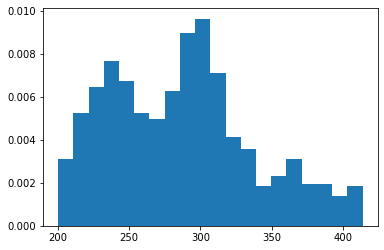

In [473]:
plt.hist(datos1,bins = 20,density = True);

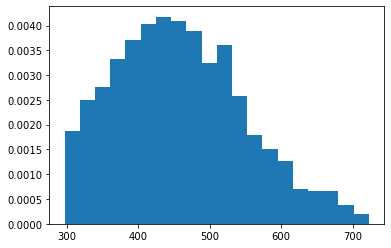

In [475]:
plt.hist(datos2,bins = 20,density = True);

In [506]:
datos3 = pt_dc7.inverse_transform(np.array(datos3).reshape(-1,1))
datos3 = datos3.reshape(len(datos3))

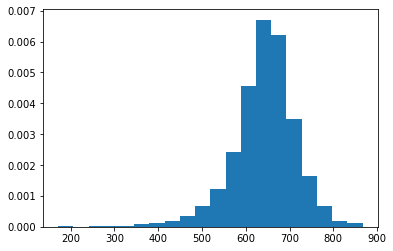

In [507]:
plt.hist(datos3,bins = 20,density = True);

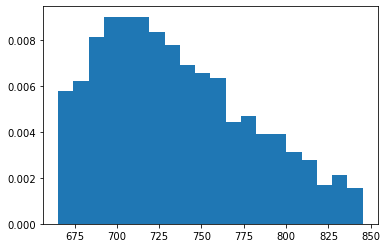

In [490]:
plt.hist(datos4,bins = 20,density = True);